In [1]:
cd(@__DIR__)
using Pkg
Pkg.activate(".")

  Activating project at `~/Teaching/nn-zero-to-hero/julia/Makemore`


In [2]:
begin
    using Flux
    using Zygote
    using Random
    using Distributions
    using Plots
    using StatsBase
    using Statistics
end

[ Info: Precompiling Flux [587475ba-b771-5e3f-ad9e-33799f191a9c]
[ Info: Precompiling Distributions [31c24e10-a181-5473-b8eb-7969acd0382f]
[ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]


In [3]:
using ProgressMeter

In [4]:
begin
    data_url = "https://raw.githubusercontent.com/karpathy/makemore/master/names.txt"
    dat = download(data_url)
end;

In [5]:
words = readlines(dat; keep=false);

In [6]:
begin
    # chars = collect('a':'z')
    chars = sort(unique(join(words)))
    num_chars = length(chars) 
    # push!(chars, '.')
    insert!(chars, 1, '.')
    stoi = Dict(zip(chars, 1:length(chars)))
    itos = Dict(zip(1:length(chars), chars))
end;

In [7]:
vocab = chars;

In [8]:
block_size = 3

3

In [9]:
# block_size = 3

# ys = Array{Int}(undef, 0)
# Xs = []
# context = repeat('.', block_size) 
# for c in w
#     push!(Xs, [stoi[c] for c in context])
#     push!(ys, stoi[c])
#     println(context, " ---> ", c)
#     context = context[2:end] * c
# end


In [10]:
function build_dataset(words)
    Y = []
    X = []
    for w in words
        context = repeat('.', block_size) 
        for c in w * '.'
            push!(X, [stoi[c] for c in context])
            push!(Y, stoi[c])
#             println(context, " ---> ", c)
            context = context[2:end] * c
        end
    end
    return hcat(X...), hcat(Y...)
end

build_dataset (generic function with 1 method)

In [11]:
X, Y = build_dataset(words);

([1 1 … 27 26; 1 1 … 26 27; 1 6 … 27 25], [6 14 … 25 1])

In [12]:
size(X), size(Y)

((3, 228146), (1, 228146))

In [13]:
# split the data to train, dev, test
Random.seed!(42)

shuffle!(words)
n1 = floor(Int, 0.8 * length(words))
n2 = floor(Int, 0.9 * length(words))
Xtr, Ytr = build_dataset(words[1:n1])
Xdev, Ydev = build_dataset(words[(n1+1):n2])
Xte, Yte = build_dataset(words[(n2+1):end]);

([1 1 … 2 13; 1 1 … 13 10; 1 18 … 10 27], [18 22 … 27 1])

In [14]:
Embedding(27=>2)

Embedding(27 => 2)  # 54 parameters

In [15]:
# embedding 
C = randn(2, 27)

2×27 Matrix{Float64}:
 1.50014   1.3321   2.4653    2.03043  …  -0.139152   0.718401  2.04768
 0.634146  1.57173  1.68428  -1.1982      -1.19438   -0.335327  1.98373

In [16]:
C[:,[1 2 3; 1 2 3; 1 2 3]]

2×3×3 Array{Float64, 3}:
[:, :, 1] =
 1.50014   1.50014   1.50014
 0.634146  0.634146  0.634146

[:, :, 2] =
 1.3321   1.3321   1.3321
 1.57173  1.57173  1.57173

[:, :, 3] =
 2.4653   2.4653   2.4653
 1.68428  1.68428  1.68428

In [17]:
# [1 2 3; 1 2 3]

In [18]:
# Flux.onehotbatch("cat&dog", 'a':'z', 'n')

In [19]:
# dim of the embedding layer
dim = 2
C = Embedding(length(vocab)=>dim)

Embedding(27 => 2)  # 54 parameters

In [20]:
C(Xtr) |> size

(2, 3, 182406)

In [21]:
reshape(C(Xtr), 6, :) ==  C(Xtr) |> Flux.flatten

true

In [24]:
data = Flux.DataLoader((Xtr, Ytr), batchsize=32);

5701-element DataLoader(::Tuple{Matrix{Int64}, Matrix{Int64}}, batchsize=32)
  with first element:
  (3×32 Matrix{Int64}, 1×32 Matrix{Int64},)

In [26]:
targets = Flux.onehotbatch(Ytr[:], 1:length(vocab))
mini_batches = Flux.DataLoader((Xtr, targets), batchsize=32);

5701-element DataLoader(::Tuple{Matrix{Int64}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=32)
  with first element:
  (3×32 Matrix{Int64}, 27×32 OneHotMatrix(::Vector{UInt32}) with eltype Bool,)

In [190]:
h1 = 200
dim = 2
act = tanh
mlp = Chain(
    Embedding(length(vocab) => dim), 
    Flux.flatten, 
    Dense(block_size * dim => h1, act), 
    Dense(h1, length(vocab))
)

Chain(
  Embedding(27 => 2),                   # 54 parameters
  Flux.flatten,
  Dense(6 => 200, tanh),                # 1_400 parameters
  Dense(200 => 27),                     # 5_427 parameters
)                   # Total: 5 arrays, 6_881 parameters, 27.191 KiB.

In [191]:
# idx = rand(1:size(Xtr)[2], 5)
# Xtr[:, idx]
# targets[:, idx]

In [192]:
# stepi, lossi, mlp_sgd = let
    
#     h1 = 200
#     dim = 2
#     act = tanh
#     mlp = Chain(
#         Embedding(length(vocab) => dim), 
#         Flux.flatten, 
#         Dense(block_size * dim => h1, act), 
#         Dense(h1, length(vocab))
#     )
    
    
#     lossi = []
#     stepi = []
#     tr_size = size(Xtr)[2]
#     batch_size = 32
#     for iter in 1:200_000
# #        mini batches
#         ix = rand(1:tr_size, batch_size)
#         xs = Xtr[:, ix]
#         ys = targets[:, ix]
        
#         loss, grads = Flux.withgradient(mlp) do m
#             ŷ = m(xs)
#             Flux.Losses.logitcrossentropy(ŷ, ys)
#         end
        
        
# #     gradient descent
#         opt = iter < 100000 ? Descent(0.1) : Descent(0.01)
# #         for p in params
# #             p.data +=  -lr * p.grad
# #         end
        
# #         opt = Descent(0.3)
#         Flux.update!(Flux.setup(opt, mlp), mlp, grads[1])
#         push!(lossi, loss)
#         push!(stepi, iter)
#     end
    
#     stepi, lossi, mlp
# end

In [193]:
# plot(lossi)

In [194]:
# lossi[end], Flux.Losses.logitcrossentropy(mlp_sgd(Xtr), Flux.onehotbatch(Ytr[:], 1:length(vocab)))

In [195]:
optim = Flux.setup(Flux.Adam(0.01), mlp)

(layers = ((weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))),), (), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], (0.9, 0.999))), σ = ()), (weight = Leaf(Adam{Float64}(0.01, (0.9, 0.999), 1.0e-8), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], (0.9, 0.999))), bia

In [196]:
losses = []

@showprogress for epoch in 1:300
#     loss = 0f0
    for (x, y) in mini_batches
        loss, grads = Flux.withgradient(mlp) do m
            ŷ = m(x)
            Flux.Losses.logitcrossentropy(ŷ, y)
        end
        Flux.update!(optim, mlp, grads[1])
        push!(losses, loss)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:14


In [197]:
# gr()
# plot(losses; xaxis= "epoch",
#     yaxis="loss", label="per batch")
# plot(losses; xaxis=(:log, "epoch"),
#     yaxis="loss", label="per batch")
# n = length(mini_batches)
# plot!(n:n:length(losses), mean.(Iterators.partition(losses, n)),
#     label="epoch mean", dpi=200)

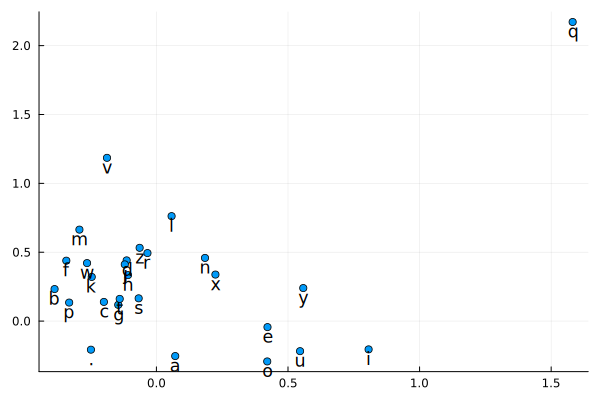

GKS: could not find font monospace.ttf


In [163]:
C_ = mlp[1].weight
# plotly()
scatter(C_[1,:], C_[2,:], series_annotations = text.(vocab, :top, 12, family="monospace"), label="")

In [124]:
Flux.Losses.logitcrossentropy(mlp(Xdev), Flux.onehotbatch(Ydev[:], 1:length(vocab)))

2.3920593f0

In [125]:
Flux.Losses.logitcrossentropy(mlp(Xte), Flux.onehotbatch(Yte[:], 1:length(vocab)))

2.3890026f0

In [152]:
# # model 2 with residual connection
h1_ = 200
dim_ = 2
act = relu
mlp_res = Chain(
    Embedding(length(vocab) => dim), 
    Flux.flatten, 
    Parallel(+, Dense(block_size * dim => length(vocab); bias=false), Chain(Dense(block_size * dim => h1_, act), 
    Dense(h1_, length(vocab))))
)

Chain(
  Embedding(27 => 2),                   # 54 parameters
  Flux.flatten,
  Parallel(
    +,
    Dense(6 => 27; bias=false),         # 162 parameters
    Chain(
      Dense(6 => 200, relu),            # 1_400 parameters
      Dense(200 => 27),                 # 5_427 parameters
    ),
  ),
)                   # Total: 6 arrays, 7_043 parameters, 28.066 KiB.

In [153]:
losses_res = []
optim = Flux.setup(Flux.Adam(0.01), mlp_res)
@showprogress for epoch in 1:300
    for (x, y) in mini_batches
        loss, grads = Flux.withgradient(mlp_res) do m
            ŷ = m(x)
            Flux.Losses.logitcrossentropy(ŷ, y)
        end
        Flux.update!(optim, mlp_res, grads[1])
        push!(losses_res, loss)
    end
end

Progress: 100%|█████████████████████████████████████████| Time: 0:03:37


In [188]:
plot(losses_res; xaxis=(:log, "iteration"),
    yaxis="loss", label="per batch");
n = length(mini_batches)
plot!(n:n:length(losses_res), mean.(Iterators.partition(losses_res, n)),
    label="epoch mean", dpi=200);

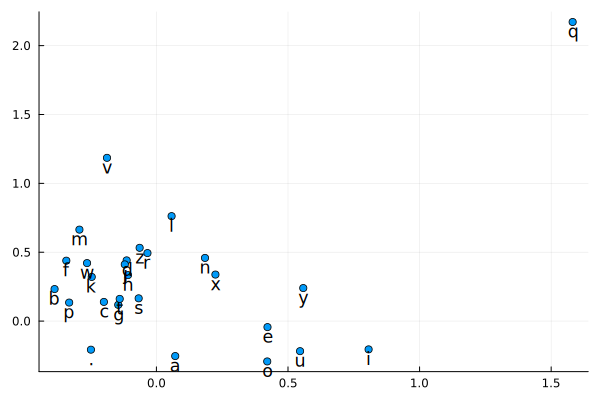

In [166]:
C_ = mlp[1].weight
# plotly()
scatter(C_[1,:], C_[2,:], series_annotations = text.(vocab, :top, 12, family="monospace"), label="")